# Chl-xTB

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re

import sys
sys.path.append("../src/")

import analysis
import partition_energy

#import matplotlib
#font = {'size'   : 22}

#matplotlib.rc('font', **font)

In [2]:
states = partition_energy.read_splits("states_energies", (1000, 28), "100ps_10fs")
states.shape

(10000, 28)

In [3]:
exciton_energies = np.array([states[:,i] - states[:,0] for i in range(1, states.shape[1])]).T
exciton_energies.shape

(10000, 27)

## Partition Function


$$ Z=\sum_i e^{-bE_i} $$

$$ U=\sum_i w_i E_i $$

$$ w_i = \frac{e^{-bE_i}}{Z} $$

$$ b=\frac{1}{kT} $$

(10000, 27)
(10000,)


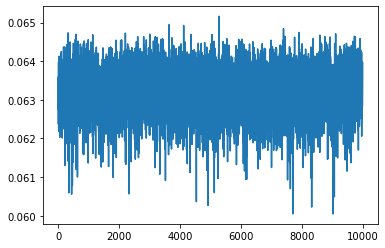

In [4]:
def thermal_energy(energies):
    boltzmann_eV = 8.617333262145e-5 # eV / K
    hr_to_eV = 27.2114 # eV / hr

    boltzmann_hr = boltzmann_eV / hr_to_eV

    T = 300 # K 

    beta = 1 / (boltzmann_hr * T)

    E = energies

    boltz_factor = np.exp(-beta * E)
    
    Z = np.sum(boltz_factor, axis=1)
    
    print(boltz_factor.shape)
    print(Z.shape)

    w = (boltz_factor.T / Z).T

    U = np.sum(E * w, axis=1)
    
    return U

U = thermal_energy(exciton_energies)
plt.plot(U)

## Spectral Density

In [5]:
U_rel = U - np.mean(U)
autocorr, spectrum, spectrum_normal_domain = analysis.spectrum_and_domain(U_rel, 10)

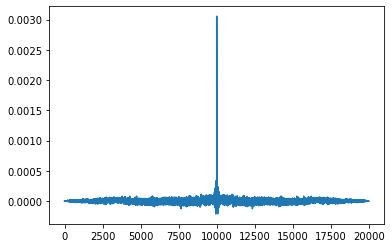

In [6]:
plt.plot(autocorr[:len(autocorr)//5])

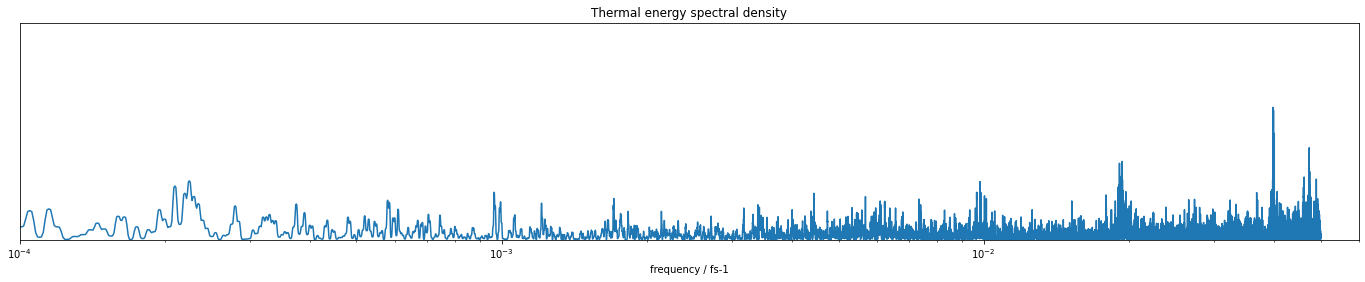

In [7]:
fig, ax = plt.subplots()

ax.plot(analysis.first_half(spectrum_normal_domain), analysis.first_half(np.abs(spectrum)))
ax.set_ylim(0, )

ax.set_xlim(1e-4, 6e-2)
ax.set_xscale('log')

fig.set_size_inches(24, 4)
ax.set_title("Thermal energy spectral density")
ax.set_xlabel("frequency / fs-1")
ax.set_yticks([]);

Text(0.5, 0, 'frequency / fs-1')

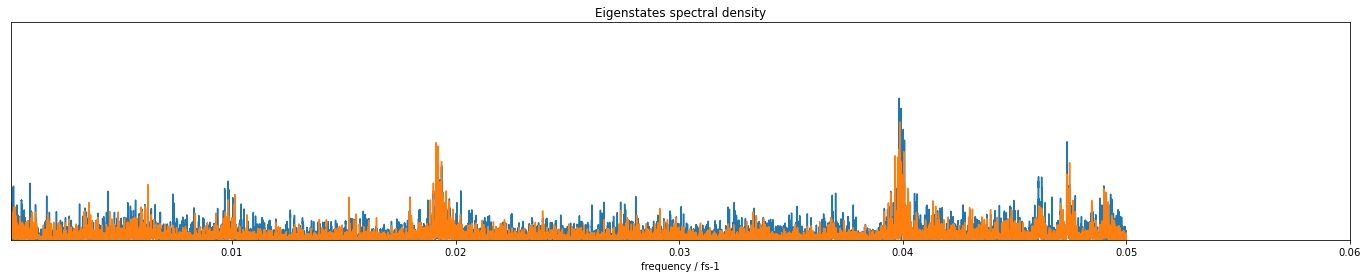

In [8]:
def spectrum_eigenstate(all_data, ax, i):
    assert(i != 0)
    diff = all_data[:,i] - all_data[:,0]
    diff_rel = diff - np.mean(diff)
    autocorr, spectrum, spectrum_normal_domain = analysis.spectrum_and_domain(diff_rel, 10)

    ax.plot(analysis.first_half(spectrum_normal_domain), analysis.first_half(np.abs(spectrum)))
    

fig, ax = plt.subplots()

spectrum_eigenstate(states, ax, 1)
spectrum_eigenstate(states, ax, 2)
#spectrum_eigenstate(all_data, ax, 0)

ax.set_ylim(0,)
ax.set_xlim(1e-4, 6e-2)
#ax.set_xscale('log')

ax.set_yticks([])
fig.set_size_inches(24, 4)

ax.set_title("Eigenstates spectral density")
ax.set_xlabel("frequency / fs-1")

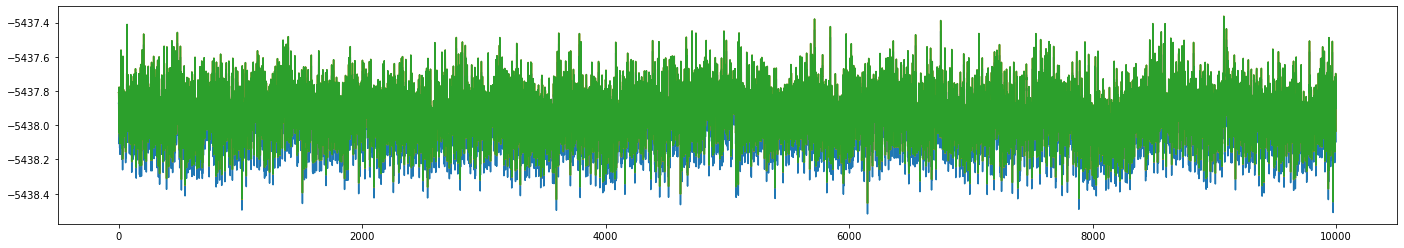

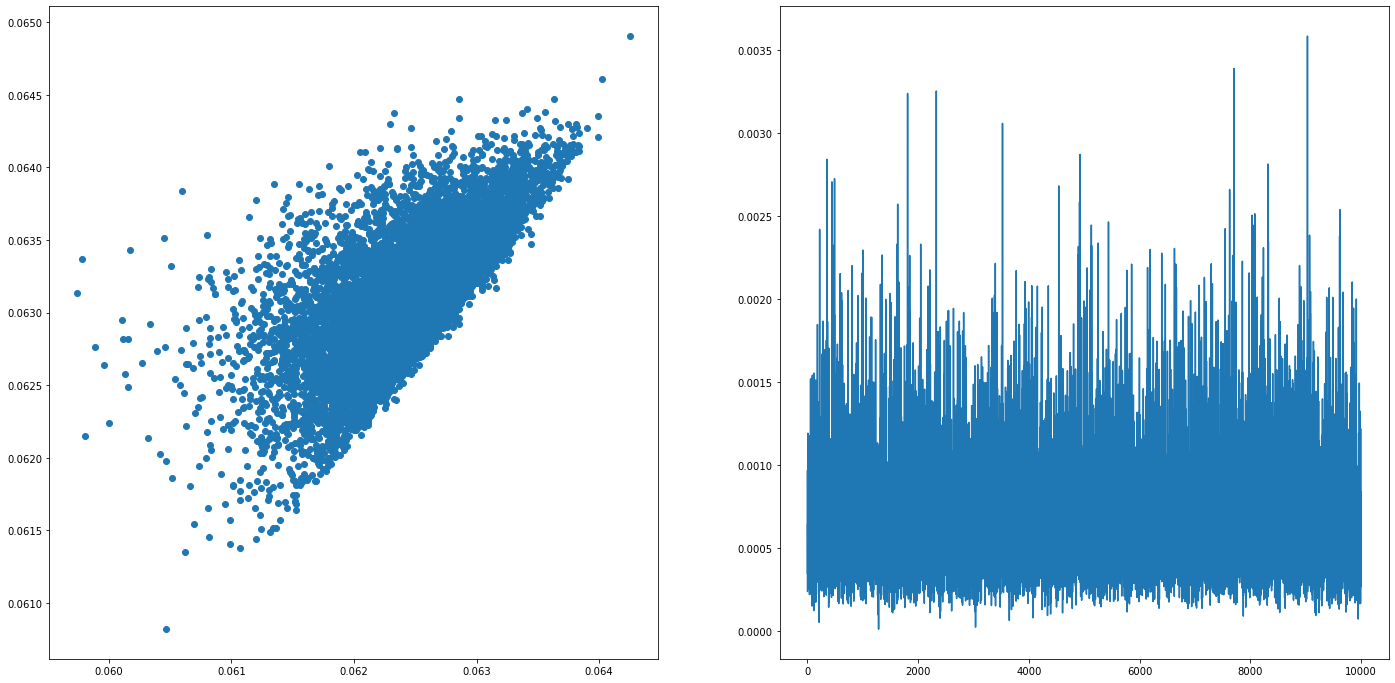

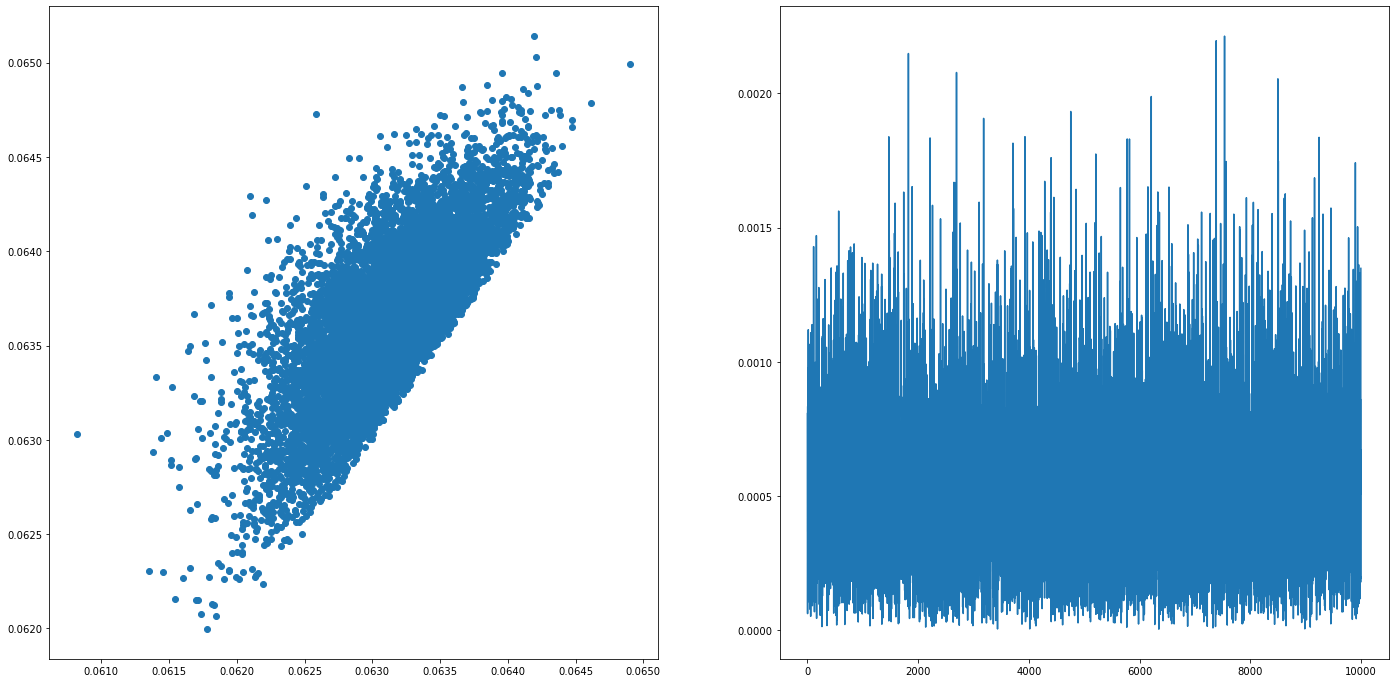

In [9]:
fig, ax = plt.subplots()

site_energies = partition_energy.read_splits("transition_energies", (1000, 27), "100ps_10fs")

ax.plot(states[:,0])
ax.plot(states[:,1])
ax.plot(states[:,2])

fig.set_size_inches(24, 4)


fig, ax = plt.subplots(1, 2)

ax[0].scatter(states[:,1]-states[:,0], states[:,2]-states[:,0])
ax[1].plot((states[:,2]-states[:,0]) - (states[:,1]-states[:,0]))

fig.set_size_inches(24, 12)


fig, ax = plt.subplots(1, 2)

ax[0].scatter(exciton_energies[:, 1], exciton_energies[:, 2])
ax[1].plot(exciton_energies[:, 2] - exciton_energies[:, 1])

fig.set_size_inches(24, 12)


In [10]:
time_ranges = np.ptp(states, axis=1)
assert(time_ranges.shape[0] == 10000)

state_ranges = np.var(states, axis=0)
assert(state_ranges.shape[0] == 28)

print(f"""
(average) range of energies along the time series : {np.mean(time_ranges):3.6f}
(average) range of energies along the state series: {np.mean(state_ranges):3.3f}
""")


(average) range of energies along the time series : 0.070881
(average) range of energies along the state series: 0.023



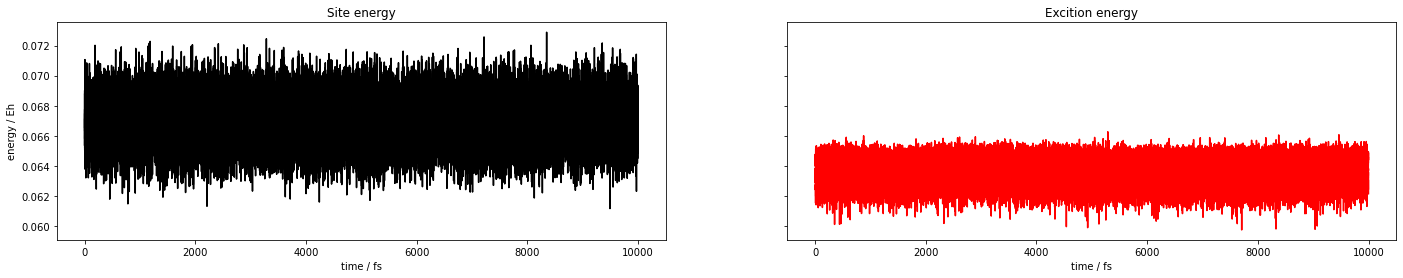

In [11]:
site_energies = partition_energy.read_splits("transition_energies", (1000, 27), "100ps_10fs")

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)

for i in range(0, 5):
    ax[0].plot(site_energies[:,i], color='black')
    ax[1].plot(exciton_energies[:, i], color='red')

ax[0].set_title("Site energy")
ax[1].set_title("Excition energy")

ax[0].set_ylabel("energy / Eh")

ax[0].set_xlabel("time / fs")
ax[1].set_xlabel("time / fs")
fig.set_size_inches(24, 4)

(10000, 27)
1 2 

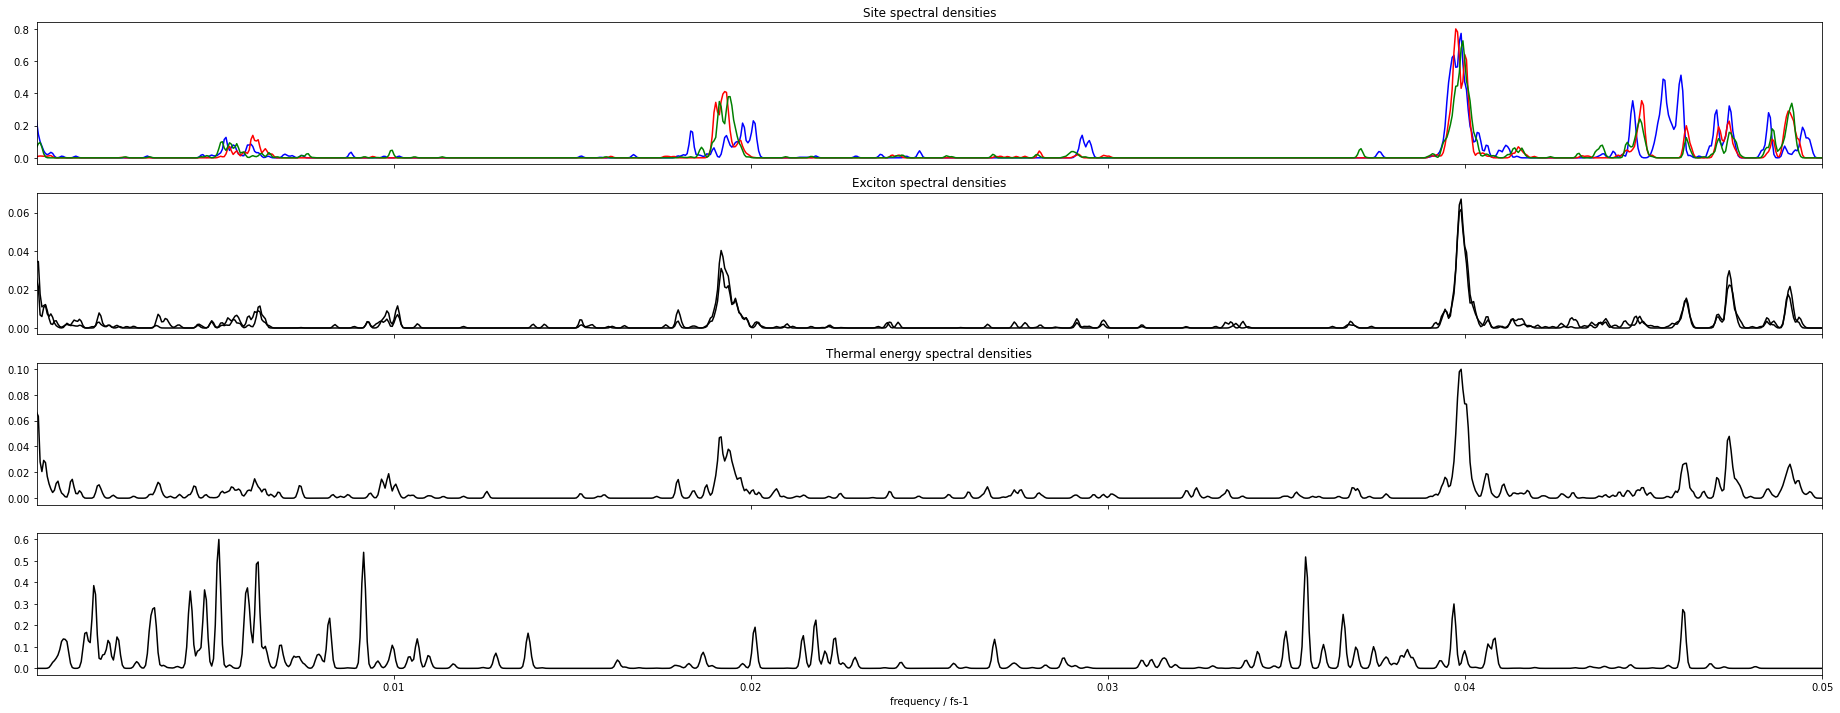

In [14]:
def gaussian(x, mu, s, a):
    if abs(x-mu) > 3 * mu:
        return 0
    
    return a * np.exp(-0.5 * ((x-mu) / s)**2)


def make_gaussian(mu, s, a):
    return lambda x : gaussian(x, mu, s, a)


def gaussians_static_broadening(series, domain, broadening, cutoff):
    
    funcs = [make_gaussian(d0, broadening, amp) for amp, d0 in zip(series, domain) if amp > cutoff]
    return lambda x : np.sum([g(x) for g in funcs])


def gaussians_variable_broadening(series, domain, broadening, cutoff):
    
    funcs = [make_gaussian(d0, diff * broadening, amp) for amp, d0, diff in zip(series, domain, np.diff(domain)) if amp > cutoff]
    return lambda x : np.sum([g(x) for g in funcs])


def plot_gaussians(broadening, max_amp, ax, color='black'):
    #plotting
    fs = np.linspace(0, 5e-2, 1000)
    b = np.array([broadening(x) for x in fs])
    
    b *= max_amp / max(b)
    
    ax.plot(fs, b, color=color)


def broadened_spectral_density(prop, ax, color='black'):
    #load energies
    prop_rel = prop - np.mean(prop)

    #spectral density
    autocorr, spectrum, spectrum_normal_domain = analysis.spectrum_and_domain(prop_rel, 10)
    
    max_amp = max(analysis.first_half(np.abs(spectrum)))
    
    #gaussian broadening
    cutoff = 0.1 * max_amp
    broadening = gaussians_variable_broadening(analysis.first_half(np.abs(spectrum)), analysis.first_half(spectrum_normal_domain), broadening=50, cutoff=cutoff)
    
    plot_gaussians(broadening, max_amp, ax)

    
def broadened_average_spectral_density(prop, ax, indices, color='black'):
    #load energies
    
    sum_spectrum = None
    
    for i in indices:
        prop_rel = prop[:, i] - np.mean(prop[:, i])

        #spectral density
        autocorr, spectrum, spectrum_normal_domain = analysis.spectrum_and_domain(prop_rel, 10)
    
        if sum_spectrum is None:
            sum_spectrum = np.abs(spectrum)
            
        else:
            sum_spectrum += np.abs(spectrum)
            
    sum_spectrum /= len(indices)
    
    
    max_amp = max(analysis.first_half(np.abs(spectrum)))
    
    #gaussian broadening
    cutoff = 0.1 * max_amp
    broadening = gaussians_variable_broadening(analysis.first_half(np.abs(spectrum)), analysis.first_half(spectrum_normal_domain), broadening=50, cutoff=cutoff)
    
    #plotting
    fs = np.linspace(0, 5e-2, 1000)
    b = np.array([broadening(x) for x in fs])
    
    b *= max_amp / max(b)
    
    ax.plot(fs, b, color=color)


site_energies = partition_energy.read_splits("transition_energies", (1000, 27), "100ps_10fs")
    
fig, ax = plt.subplots(4, 1, sharex=True)

ax[0].set_xlim(1e-6, 5e-2)

colors=["red", "blue", "green"]

print(site_energies.shape)

#Sites excitations
ax[0].set_title("Site spectral densities")

#b800
b850a = list(range(0, 27, 3))
b800 = list(range(1, 27, 3))
b850b = list(range(2, 27, 3))
broadened_average_spectral_density(site_energies, ax[0], b800, color="blue")
broadened_average_spectral_density(site_energies, ax[0], b850a, color="red")
broadened_average_spectral_density(site_energies, ax[0], b850b, color="green")

#Exciton excitations
ax[1].set_title("Exciton spectral densities")
for i in range(1,3):
    print(i, end=" ")
    broadened_spectral_density(exciton_energies[:, i], ax[1])

#Thermal energy
ax[1].set_title("Exciton spectral densities")
broadened_spectral_density(U, ax[2])

ax[2].set_title("Thermal energy spectral densities")


import json
with open("../data/hessians/huang_rhys.json") as hr_json:
    res = json.load(hr_json)
    
hrfs = [res[x]["hrf"] for x in res.keys()]
wavenumbers = [res[x]["wavenumber"] for x in res.keys()]
freqs = [res[x]["frequency"] for x in res.keys()]

hrf_broadening = gaussians_static_broadening(hrfs, freqs, 0.00006, 0)
plot_gaussians(hrf_broadening, 0.6, ax[3])
ax[3].set_xlabel("frequency / fs-1")

#ax[0].set_xscale('log')
#ax[1].set_xscale('log')
#ax[2].set_xscale('log')
#ax[3].set_xscale('log')

fig.set_size_inches(32, 12)

0 

NameError: name 'first_half' is not defined

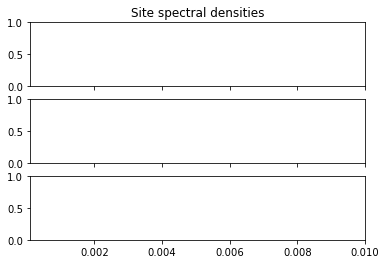

In [13]:
def broadened_spectral_density(energies, ax, i):
    #load energies
    if len(energies.shape) > 1:
        energy_rel = energies[i] - np.mean(energies[i])

    else:
        energy_rel = energies - np.mean(energies)

    #spectral density
    autocorr, spectrum, spectrum_normal_domain = analysis.spectrum_and_domain(energy_rel, 10)
    
    max_amp = max(first_half(np.abs(spectrum)))
    
    #gaussian broadening
    #cutoff = 0.01 * max_amp
    #broadening = gaussians(first_half(np.abs(spectrum)), first_half(spectrum_normal_domain), broadening=0.00007, cutoff=cutoff)
    
    #plotting
    #fs = np.linspace(1e-5, 1e-3, 1000)
    #b = np.array([broadening(x) for x in fs])
    
    #b *= max_amp / max(b)
    
    #ax.plot(fs, b, color='black')
    
    ax.plot(first_half(spectrum_normal_domain), first_half(np.abs(spectrum)))


fig, ax = plt.subplots(3, 1, sharex=True)

ax[0].set_xlim(1e-4, 1e-2)

#Sites excitations
ax[0].set_title("Site spectral densities")
for i in range(27):
    print(i, end=" ")
    broadened_spectral_density(site_energies, ax[0], i)
ax[0].set_ylim(0, 2)

#Exciton excitations
ax[1].set_title("Exciton spectral densities")
for i in range(27):
    print(i, end=" ")
    broadened_spectral_density(exciton_energies, ax[1], i)
ax[1].set_ylim(0, 0.2)

#Thermal energy
ax[1].set_title("Exciton spectral densities")
broadened_spectral_density(U, ax[2], _)

ax[2].set_xlabel("frequency / fs-1")
ax[2].set_ylim(0, 100)
fig.set_size_inches(24, 12)
